In [1]:
# import all relevant libraries dependencies and set up the backend
import numpy as np
import time
import progressbar
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import exact_diagonalisation.ed_hubbard as ED 
import qsharp
from qsharp import Result
from Quantum.Hubbard import Evolve, EvolveSingleTimestepDummy

tabcols = list(mcolors.TABLEAU_COLORS)

# Time Evolution

Assumes a chain of lench L, a ladder of size L x 2 or an L x L lattice of sites. Uses the values of J, U and $\mu$ to evolve.

\begin{equation}\label{eq:}
H = -J\sum_{i, j}\sum_{\sigma} (c^{\dagger}_{i, \sigma}c_{j, \sigma} + h.c) + U\sum_{i}n_{i, \uparrow}n_{i, \downarrow} - \mu\sum_{i}\sum_{\sigma}n_{i, \sigma}
\end{equation}

A random initial state with N1 spin downs and N2 spin ups is generated where N1 and N2 are provided by the user

In [2]:
# define system parameters
attempt_ED = True
p = {}
p['L'] = 3 # system length
p['W'] = 1 # system width
p['N1'] = 1 # number of particles in 1
p['N2'] = 1 # number of particles in 2
p['t1'] = p['t2'] = J = 0.5 # hopping
p['U12'] = U = 0.3 # on-site interaction between 1 and 2
p['mu1'] = p['mu2'] = mu = 0 # chemical potential
p['t_initial'] = 0.0 # begin of time evolution
p['dt'] = dt = 0.01 # time-step
p['t_final'] = total_time = 1.0 # end of time evolution
p['N'] = N = p['L'] * p['W'] # system size
ave = 500
if p['W'] == 2:
    structure = 3 # ladder 
elif p['W'] == p['L']:
    structure = 4 # lattice
else:
    structure = 1 # chain
if N > 9:
    attempt_ED = False

In [3]:
# generate random initial state
initial_state = [0 for _ in range(N)]
N1s = np.random.choice(range(N), p['N1'], replace=False)
N2s = np.random.choice(range(N), p['N2'], replace=False)
for i in N1s:
    initial_state[i] += 1
for i in N2s:
    initial_state[i] += 2

In [6]:
# do exact evolution
if attempt_ED:
    state_table = ED.generate_state_table(p)
    tic = time.time()
    sim, state_table = ED.evolve(
        p, state_table, initial_state, kind="list",
        correlation_measurement=False, trotterised=True)
    toc = time.time()
    print("Exact evolution took ", toc-tic, "s")

Exact evolution took  0.07952523231506348 s


In [7]:
# do qsharp evolution
tic = time.time()
times = np.linspace(0, total_time, num=10)
result_up = np.zeros((len(times), len(initial_state)))
result_down = np.zeros((len(times), len(initial_state)))
progress_bar = progressbar.ProgressBar(max_value=ave)
points_taken = 0
for _ in range(ave):
    for i, t in enumerate(times):
        res = Evolve.simulate(
            initialState=initial_state, time=t, dt=dt, mu=mu, U=U, J=J,
            structure=structure)
        result_up[i] += ED.project_state_into_spinsectors(res)[0] / ave
        result_down[i] += ED.project_state_into_spinsectors(res)[1] / ave
    points_taken += 1
    progress_bar.update(points_taken)
toc = time.time()
print("Q# Evolution took {} mins {} s".format(int((toc-tic) // 60), int((toc-tic) % 60)))

100% (500 of 500) |######################| Elapsed Time: 0:13:19 ETA:  00:00:00

Q# Evolution took 13 mins 21 s


<Figure size 432x288 with 0 Axes>

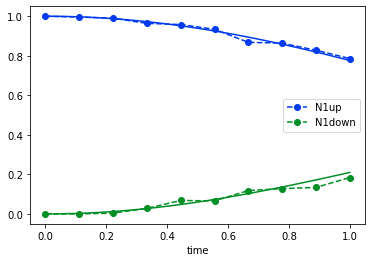

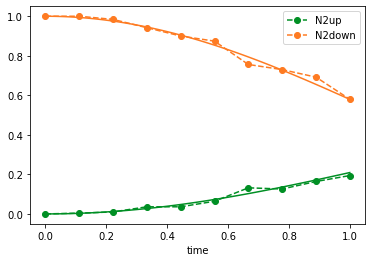

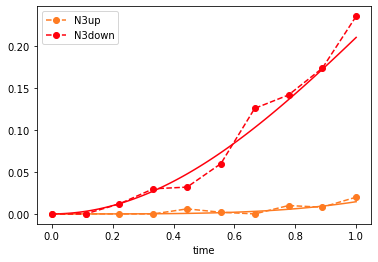

In [16]:
# plottable_times = np.append(np.array([0]), times)
fig = plt.figure()
for i in range(len(initial_state)):
    fig = plt.figure()
    if attempt_ED:
        plt.plot(sim['Time'], sim['Re(N1 Site {})'.format(i + 1)], color=colors[i])
        plt.plot(sim['Time'], sim['Re(N2 Site {})'.format(i + 1)], color=colors[i + 1])
    plt.plot(times, result_up[:, i], 
             color=tabcols[i], marker='o', linestyle='--', label='N{}up'.format(i + 1))
    plt.plot(times, result_down[:, i], 
             color=tabcols[i + 1], marker='o', linestyle='--', label='N{}down'.format(i + 1))
    plt.xlabel('time')
    plt.legend()

# Resource Estimation

Estimate the resources for the full evolution (1st order) and for a single timestep. Currently the depth only measures T gates of which there are none. The number of Cliffords and Rotations will be slightly off because the Y gate is implemented as a Rotation in Q# as it is not in the 'Intrinsic' gate set.

In [4]:
# estimate resources
full_gatecount = Evolve.estimate_resources(initialState=initial_state, time=total_time, dt=dt, mu=mu, U=U, J=J,
                                           structure=structure)
timestep_gatecount = EvolveSingleTimestepDummy.estimate_resources(
                        initialState=initial_state, dt=dt, mu=mu, U=U, J=J, structure=structure)

print('Full Evolution')
print(*['\t{}: {}\n'.format(k, v) for k, v in full_gatecount.items()])
print('Single Timestep')
print(*['\t{}: {}\n'.format(k, v) for k, v in timestep_gatecount.items()])

Full Evolution
	CNOT: 2200
 	QubitClifford: 1602
 	R: 3300
 	Measure: 6
 	T: 0
 	Depth: 0
 	Width: 6
 	BorrowedWidth: 0

Single Timestep
	CNOT: 22
 	QubitClifford: 16
 	R: 33
 	Measure: 0
 	T: 0
 	Depth: 0
 	Width: 6
 	BorrowedWidth: 0

